#### Y layer on Data 

Lets see how it works 

In [3]:
import numpy as np
import matplotlib.pyplot as plt

ruta_layer2 = "activation_layer2.txt"  
with open(ruta_layer2, "r") as f:
    # Rewrite data in a list
    data_layer2 = [list(map(int, line.strip().split())) for line in f]
# Rewrite as numpy array
X_layer2 = np.array(data_layer2)
print("Capa 2 cargada:", X_layer2.shape)  

Capa 2 cargada: (184800, 250)


In [5]:
def activation(z, func="sigmoid"):
    """
    Funciones de activación: step, sigmoid, tanh, relu.
    """
    if func == "step":
        return np.where(z >= 0, 1.0, -1.0)
    elif func == "sigmoid":
        return 1 / (1 + np.exp(-z))
    elif func == "tanh":
        return np.tanh(z)
    elif func == "relu":
        return np.maximum(0.0, z)
    else:
        raise ValueError(f"Función '{func}' no reconocida")

def simulate_layers(S, J=5, eps=0.1, func="sigmoid"):
    """
    Simula J capas de 'conciencia' a partir de la serie de estados S.
    - S: matriz de estados (T, n) en {-1,+1} (o {0,1} si no lo pasamos a -1/+1).
    - J: número de capas
    - eps: tasa de actualización (0<eps<=1)
    - func: función de activación
    Devuelve A de forma (T, J) con cada a_t^j.
    """
    T, n = S.shape
    A = np.zeros((T, J))
    W = np.random.normal(0, 1, size=(J, n))  # pesos aleatorios por capa
    a_vals = np.zeros(J)  # valores iniciales de cada capa (a_0^j = 0)

    for t in range(T):
        for j in range(J):
            z = W[j] @ S[t]
            out = activation(z, func=func)
            a_vals[j] = (1 - eps) * a_vals[j] + eps * out
            A[t, j] = a_vals[j]
    return A

def Y_layer(A_t, sigma_inputs):

    J = len(A_t)
    score = 0.0
    num_pares = J * (J - 1) / 2
    for j in range(J):
        for j_prime in range(j + 1, J):
            delta_a = A_t[j] - A_t[j_prime]
            delta_sigma = sigma_inputs[j] - sigma_inputs[j_prime]
            score += delta_a * delta_sigma
    return score / num_pares


KeyboardInterrupt: 

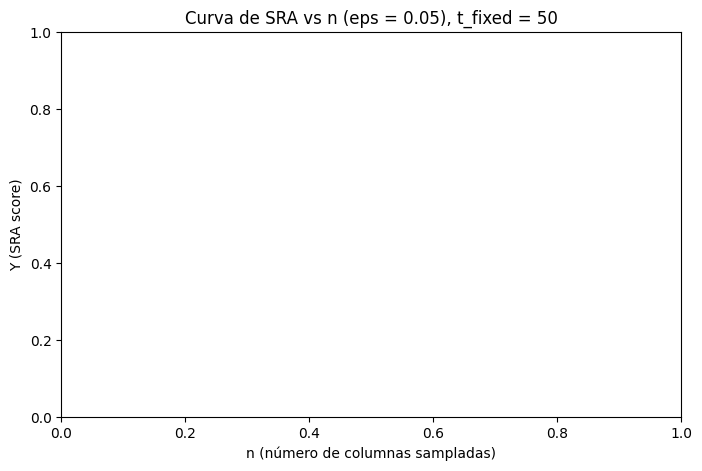

In [6]:
eps_values = [0.05, 0.5, 0.9]
n_samples = 30
t_fixed = 50  # por ejemplo
J = 50
func = "sigmoid"
lista_n = [20, 60, 120]

# layers & simulations
for eps in eps_values:
    plt.figure(figsize=(8, 5))
    plt.title(f"Curva de SRA vs n (eps = {eps:.2f}), t_fixed = {t_fixed}")
    plt.xlabel("n (número de columnas sampladas)")
    plt.ylabel("Y (SRA score)")

    medias_por_n = []
    stds_por_n = []

    # Recorro cada tamaño de sub‐conjunto n0
    for n0 in lista_n:
        sra_replicas = np.zeros(n_samples)

        # Hago n_samples repeticiones para promediar
        for rep in range(n_samples):
            # 3.1) Tomar aleatoriamente n0 columnas de las 250 de X_layer2
            idx_cols = np.random.choice(
                X_layer2.shape[1], size=n0, replace=False
            ) 
            #      S_real tendrá forma (T_real, n0)
            S_real = X_layer2[:, idx_cols]
            S = 2 * S_real - 1
            T_real, _ = S.shape

            # Asegurémonos de no desbordar t_fixed
            if t_fixed >= T_real:
                raise ValueError(
                    f"t_fixed = {t_fixed} es mayor que T_real = {T_real}. Reduce t_fixed o recorta tus datos."
                )
            
            # 3.4) Simular las J capas de conciencia sobre toda la serie S
            A = simulate_layers(S, J=J, eps=eps, func=func)
            W_prime = np.random.normal(0, 1, size=(J, n0))
            sigma_inputs = activation(W_prime @ S[t_fixed], func=func)
            # 3.6) Calcular el SRA score en t_fixed
            Yt = Y_layer(A[t_fixed], sigma_inputs)
            sra_replicas[rep] = Yt

        # Calculo estadísticos sobre las replicas
        medias_por_n.append(sra_replicas.mean())
        stds_por_n.append(sra_replicas.std())

    # Ahora ploteo los puntos (n=20, n=60, n=120) con barras de desviación
    medias_por_n = np.array(medias_por_n)
    stds_por_n = np.array(stds_por_n)
    plt.errorbar(
        lista_n,
        medias_por_n,
        yerr=stds_por_n,
        fmt="o-",
        capsize=5,
        label=f"eps = {eps:.2f}"
    )

    plt.xticks(lista_n)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()